## Проектная работа "Аналитика Данных"

<div class="alert alert-info">
<b>"Анализ продаж онлайн-розничной торговли</b> 
    
<b>(поиск точек роста, составление рекомендаций стейкхолдерам, построение предиктивной модели)".</b> 
</div>

In [1]:
# Импортируем все необходимые библиотеки для анализа и визуализаций
import pandas as pd 
import numpy as np
from datetime import datetime
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as image

In [2]:
# Для построения и обучения модели линейной регрессии
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
# Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 13,6

In [26]:
# Загрузим датасет для анализа 
# Это набор данных, который содержит все транзакции, произошедшие с 01.12.2010 по 09.12.2011 в онлайн-магазине в Великобритании. 
# Компания продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками.
df = pd.read_csv('C:\\Users\\HP\\Desktop\\DataAnalitics\\data.csv', sep=',', na_values='?', encoding='cp1251')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [27]:
# Исследуем датасет на предмет качества и достаточности данных.
# посмотрим основную информацию по датасету.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540408 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [28]:
# Найдем пропуски в данных.
# Видим, что есть недостающие данные в названии товара и отсутствует 25% CustomerID - скорей всего это покупки от незарегистрированных клиентов.
# В этом случае оставляем все как есть, так как не можем восполнить пропуски средним значением.
(df.isna().mean() * 100).round(2)

InvoiceNo       0.00
StockCode       0.00
Description     0.28
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [29]:
# InvoiceDate - нужно привести к формату datetime, иначе не сможем анализировать периоды,
# а CustomerID - приведем к обьекту.
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['CustomerID'] = df.CustomerID.astype('object')

In [30]:
# Теперь с датасетом можно работать
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540408 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [31]:
# Добавим столбец  - посчитаем суммы продаж
df['Summa'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Summa
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [32]:
# Добавим столбец Date с месяцем и годом продажи, для дальнейшего анализа динамики
df['Date'] = df['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Summa,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12


In [33]:
# Добавим столбец Weekday с днем недели
df['Weekday'] = df['InvoiceDate'].apply(lambda x: x.weekday()) 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Summa,Date,Weekday
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2


In [34]:
# Выведем отрицательные кол-ва в заказах (возвраты) в отдельный датафрейм
# с ними тоже можно поработать, выяснить почему была отмена покупок?
df_cancellation = df[df.Quantity < 0].sort_values(by='Quantity', ascending=True)
df_cancellation.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Summa,Date,Weekday
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,United Kingdom,-168469.6,2011-12,4
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,-77183.6,2011-01,1
225529,556690,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.00,NaN,United Kingdom,-0.0,2011-06,1
225530,556691,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.00,NaN,United Kingdom,-0.0,2011-06,1
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838,United Kingdom,-280.8,2010-12,3


In [35]:
# Почистим датасет от выбросов (по 1.5% с каждой стороны)
q_low = df['Quantity'].quantile(0.015)
q_hi  = df['Quantity'].quantile(0.985)

df = df[(df['Quantity'] < q_hi) & (df['Quantity'] > q_low)]

In [36]:
# Посмотрим базовые статистики по датафрейму
df.describe()

,Quantity,UnitPrice,Summa,Weekday
count,522692.00000,522692.000000,522692.000000,522692.000000
mean,7.31651,3.897694,15.700041,2.439056
std,10.11818,42.150779,72.860852,1.853860
min,1.00000,-11062.060000,-11062.060000,0.000000
25%,1.00000,1.250000,3.750000,1.000000
50%,3.00000,2.100000,9.840000,2.000000
75%,10.00000,4.130000,17.340000,4.000000
max,95.00000,13541.330000,38970.000000,6.000000


### Наблюдения
* Видим, что у нас осталось 522692 строк в отчете (удалили почти 20тыс строк с выбросами).
* Максимальное кол-во продаж одного кода в одном заказе - 95 шт, минимальное - 1 шт.
* Максимальная сумма заказа - 38970 фунтов.
* В среднем заказе продается 7 штук одного кода товара.
* Среднее значение цены товара - 3,9 фунтов, средний заказ на сумму 16 фунтов.

## Показатели среднего чека

In [15]:
# Сделаем сводную таблицу по заказам
# Видим, что всего было продано 3.824.281 единиц товара на сумму 8.206.286 фунтов стерлингов.
df_invoice = df.pivot_table(index='InvoiceNo', values=['Quantity', 'Summa'], aggfunc='sum', margins=True)
df_invoice.sort_values(by='Summa', ascending=False).head(10)

,Quantity,Summa
InvoiceNo,,
All,3824281,8206285.724
556444,60,38970.000
573585,4624,16440.450
562955,2393,16231.220
548203,3515,14158.820
537632,1,13541.330
574941,2380,12050.040
A563185,1,11062.060
576365,2173,10708.720


In [16]:
# Посчитаем средний чек
# Видим, что в среднем заказе - 191 шт на сумму 410 фунтов.
df_invoice.describe()

,Quantity,Summa
count,2.002800e+04,2.002800e+04
mean,3.818934e+02,8.194813e+02
std,2.702252e+04,5.798840e+04
min,1.000000e+00,-1.106206e+04
25%,5.500000e+01,1.291650e+02
50%,1.280000e+02,2.700000e+02
75%,2.460000e+02,4.385000e+02
max,3.824281e+06,8.206286e+06


In [17]:
# Можем посчитать также моду на кол-во штук в чеке 
# самое часто встречающееся значение 1 шт.
df_invoice['Quantity'].round().mode()[0]

1

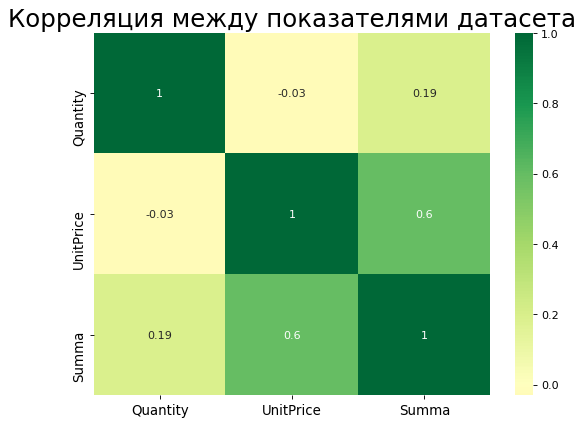

In [18]:
# Если посмотреть метрики корреляции между всеми возможными парами числовых переменных в данном наборе данных, 
# Есть небольшая зависимость между ценой и суммой.
plt.figure(figsize=(8,6), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Корреляция между показателями датасета', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Анализ динамики продаж

In [19]:
# Cделаем сводную таблицу по месяцам продаж
df_month = df.pivot_table(index='Date', values=['Quantity', 'Summa'], aggfunc='sum').reset_index()
df_month.sort_values(by='Date', ascending=True).head(14)

,Date,Quantity,Summa
0,2010-12,259426,679229.360
1,2011-01,227272,487331.460
2,2011-02,188818,421612.830
3,2011-03,257126,569294.450
4,2011-04,213329,440250.891
5,2011-05,274035,616522.170
6,2011-06,260510,584107.230
7,2011-07,284313,562863.221
8,2011-08,279382,551863.230
9,2011-09,404915,808330.502


<AxesSubplot:title={'center':'Динамика продаж по месяцам'}, xlabel='Date', ylabel='Summa'>

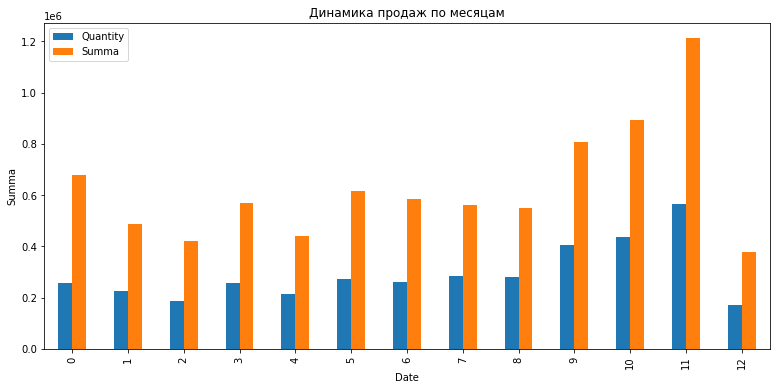

In [20]:
# С помощью визуализации можем анализировать динамику продаж. 
# Столбчатая диаграмма показывает, например, пиковый рост продаж в ноябре. 
# Здесь можно анализировать дальше: что было сделано для этого? или это случайный разовый рост? 
# Т.к. большинство клиентов магазина - оптовики, то возможная причина, что они готовились к рождеству и закупались на декабрь. 
# В декабре 2011 продажи за неполный месяц, поэтому на диаграмме падение.
df_month.plot(kind='bar', 
            title='Динамика продаж по месяцам',
            xlabel='Date',
            ylabel='Summa')

In [43]:
# Cделаем сводную таблицу продаж по дням недели (0-понедельник, 1-вторник и т.д.)
# Видим, что больше всего продают по четвергам, меньше всего по воскресеньям, и нулевые продажи по субботам.
df_weekday = df.pivot_table(index='Weekday', values='Summa', aggfunc='sum')
df_weekday.sort_values(by='Weekday', ascending=True).head(10)

,Summa
Weekday,
0,1391136.481
1,1605900.171
2,1463531.520
3,1662521.320
4,1349969.431
6,733226.801


Text(0, 0.5, 'Продажи')

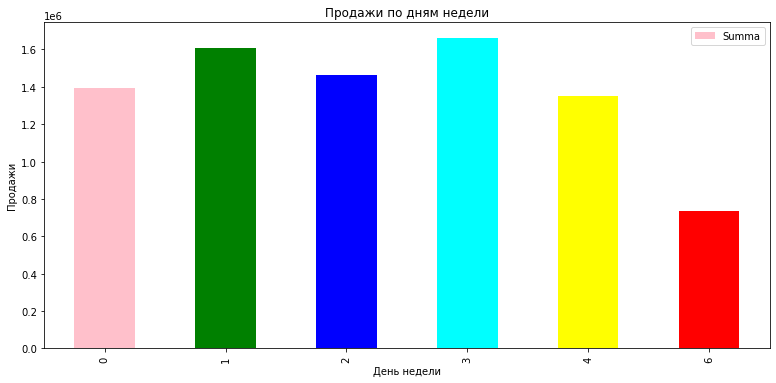

In [46]:
# Визуализируем продажи по дням недели с помощью столбчатой диаграммы
df_weekday.plot(kind='bar', 
            title='Продажи по дням недели',
            xlabel='Weekday',
            ylabel='Summa',
            color=[['pink', 'green', 'blue', 'cyan', 'yellow', 'red']])
plt.xlabel('День недели')
plt.ylabel('Продажи')

## Анализ ассортимента

In [23]:
# Сделаем сводную таблицу по товарам и посмотрим Топ-10 по кол-ву продаж (штуки).
# Особенно интересно этот отчет смотреть в динамике — кто добавился в топ, а кто вылетел.
df_code = df.pivot_table(index=['StockCode', 'Description'], columns='Date', values='Quantity', aggfunc='sum', margins=True, fill_value=0)
df_code.sort_values(by='All', ascending=False).head(10)

,Date,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,All
StockCode,Description,,,,,,,,,,,,,,
All,,258663,227064,188590,256097,212421,273448,259987,283711,278887,404673,435751,565836,172197,3817325
85123A,WHITE HANGING HEART T-LIGHT HOLDER,2389,1863,1535,1899,1785,2736,1356,1569,1580,1902,1401,2434,594,23043
84879,ASSORTED COLOUR BIRD ORNAMENT,1515,1035,1187,1590,2080,2180,1404,1749,1585,2104,2280,2998,690,22397
21212,PACK OF 72 RETROSPOT CAKE CASES,1259,1131,1375,2055,1820,1905,1216,1368,1334,1746,1599,1785,459,19052
85099B,JUMBO BAG RED RETROSPOT,952,847,1080,1371,1056,1521,1282,1429,1802,2091,1512,2099,505,17547
84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,1115,580,638,1056,1311,1493,1306,1602,1013,1883,2036,2735,743,17511
47566,PARTY BUNTING,237,486,525,1416,1737,2448,1756,2158,1345,987,520,520,136,14271
23084,RABBIT NIGHT LIGHT,0,0,0,0,0,771,1089,174,431,215,1091,7438,2511,13720
20725,LUNCH BAG RED RETROSPOT,732,688,658,1005,1025,1455,1138,1230,1604,1213,1165,1393,397,13703


In [24]:
# Посмотрим так же Топ-10 товаров по сумме продаж (фунты стерлингов).
# Еще интересно обратить внимание в данном отчете на товары, которые находятся в топе по кол-ву, но их нет в топе по выручке. 
# С такими товарами стоит отдельно поработать. Возможно, допустимо повысить на них цену?
df_code_sum = df.pivot_table(index=['StockCode', 'Description'], values='Summa', aggfunc='sum')
df_code_sum.sort_values(by='Summa', ascending=False).head(10)

,,Summa
StockCode,Description,
DOT,DOTCOM POSTAGE,206248.77
22423,REGENCY CAKESTAND 3 TIER,154906.14
47566,PARTY BUNTING,80421.65
POST,POSTAGE,78101.88
M,Manual,75391.63
85123A,WHITE HANGING HEART T-LIGHT HOLDER,64738.65
22086,PAPER CHAIN KIT 50'S CHRISTMAS,44536.91
79321,CHILLI LIGHTS,39928.40
22502,PICNIC BASKET WICKER 60 PIECES,39619.50


## Анализ клиентов

In [25]:
# Сделаем сводную таблицу по клиентам / CustomerID
# В этом отчете интересно посмотреть на тех, кто покупает больше всего. 
df_id = df.pivot_table(index=['CustomerID', 'Country'], values=['Quantity', 'Summa'], aggfunc='sum')
df_id.head()

,,Quantity,Summa
CustomerID,Country,,
12347.0,Iceland,2218,4060.40
12348.0,Finland,685,955.08
12349.0,Italy,631,1757.55
12350.0,Norway,197,334.40
12352.0,Norway,536,2506.04


In [26]:
# Для этого посчитаем топ-10 клиентов по сумме покупок
# Далее — отделу продаж взять всех, кто покупает много и регулярно на особый контроль: 
# мониторить, как у них дела (динамика), общаться и создавать для них особые предложения/условия.
df_id_sum = df_id.sort_values(by='Summa', ascending=False)
df_id_sum.head(10)

,,Quantity,Summa
CustomerID,Country,,
14911.0,EIRE,66067,131441.82
14646.0,Netherlands,36417,89884.84
14096.0,United Kingdom,16244,65030.87
14156.0,EIRE,19422,57625.02
13089.0,United Kingdom,26646,52856.95
14088.0,United Kingdom,12565,50312.81
14298.0,United Kingdom,39059,43868.07
17511.0,United Kingdom,21475,43123.68
17841.0,United Kingdom,22107,40674.85


## Анализ стран

In [27]:
# Сделаем сводную таблицу по странам покупателей - по кол-ву сделанных заказов за весь период.
# Далее можно проанализировать логистику - насколько нам выгодно (или нет) доставлять в определенные страны (при наличии данных логистических расходов)
df_country = df.pivot_table(index='Country', values='InvoiceNo', aggfunc='count').reset_index()
df_country.sort_values(by='InvoiceNo', ascending=False).head(10)

,Country,InvoiceNo
36,United Kingdom,479970
14,Germany,8952
13,France,8310
10,EIRE,7577
31,Spain,2458
3,Belgium,2021
33,Switzerland,1925
27,Portugal,1495
24,Netherlands,1348
25,Norway,1050


In [28]:
# Это страны с конца списка для анализирования актуальности развития данных направлений
df_country.sort_values(by='InvoiceNo', ascending=True).head(10)

,Country,InvoiceNo
29,Saudi Arabia,9
2,Bahrain,17
8,Czech Republic,25
4,Brazil,32
22,Lithuania,35
21,Lebanon,45
28,RSA,58
11,European Community,60
35,United Arab Emirates,68
23,Malta,112


In [29]:
# Сделаем сводную таблицу по странам покупателей - по сумме продаж за весь период.
df_country_sum = df.pivot_table(index='Country', values='Summa', aggfunc='sum').sort_values(by='Summa', ascending=False)
# Посчитаем долю в общих продажах
# Видим, что львиную долю занимает UK (85%), но можно взять под наблюдению еще 4 страны, которые вносят вклад больше 1%.
df_country_sum['Share'] = df_country_sum['Summa'] / df_country_sum['Summa'].sum() * 100
df_country_sum.style.format({'Summa': '{:.2f}'})

,Summa,Share
Country,,
United Kingdom,7018533.10,85.526307
Germany,217627.12,2.651956
EIRE,211234.51,2.574057
France,192161.85,2.341642
Netherlands,94924.88,1.156734
Switzerland,52590.50,0.640856
Australia,50344.39,0.613486
Spain,49911.33,0.608209
Belgium,40615.26,0.494929


In [30]:
# Построим сводную таблицу динамики продаж по странам (по суммам)
df_dynamics = df.pivot_table(index='Date', columns='Country', values='Summa', aggfunc='sum', margins=False, fill_value=0)
df_dynamics.head(14)

Country,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
Date,,,,,,,,,,,,,,,,,,,,,
2010-12,989.65,277.20,205.74,1646.71,0.0,0.00,363.53,1528.42,0.00,1231.10,...,0.00,0.00,0.00,1553.73,248.70,1304.92,0.00,0.00,619244.920,0.00
2011-01,4101.59,0.00,0.00,1148.36,0.0,0.00,675.58,547.50,0.00,0.00,...,0.00,0.00,1981.07,6668.97,2047.76,3717.39,0.00,0.00,404863.600,0.00
2011-02,5675.34,518.36,0.00,2181.07,0.0,0.00,1112.16,3952.16,549.26,399.22,...,0.00,145.92,0.00,2114.50,509.50,2654.92,0.00,889.24,357786.280,0.00
2011-03,6304.47,913.24,0.00,3207.98,0.0,140.54,3509.33,817.43,0.00,3523.95,...,0.00,0.00,0.00,4710.65,1165.70,1609.95,0.00,0.00,478250.220,0.00
2011-04,771.60,680.78,0.00,1989.48,1143.6,0.00,293.00,0.00,0.00,0.00,...,0.00,0.00,8137.58,1785.65,809.10,1718.94,383.95,0.00,387400.951,299.10
2011-05,5703.93,1249.43,428.40,2732.40,0.0,0.00,1207.24,0.00,0.00,515.70,...,0.00,0.00,0.00,3257.60,339.10,3610.01,0.00,0.00,520537.090,1055.87
2011-06,8390.61,0.00,0.00,4204.62,0.0,1110.98,2060.03,1109.32,0.00,3116.15,...,0.00,0.00,0.00,3333.21,832.00,6356.99,0.00,0.00,487020.100,185.78
2011-07,2592.22,1191.95,0.00,2388.53,0.0,1768.58,0.00,0.00,0.00,376.24,...,0.00,0.00,3790.92,3726.52,1525.45,3581.01,0.00,0.00,481543.231,1425.41
2011-08,4810.44,1516.08,0.00,3554.02,0.0,51.56,3464.78,0.00,0.00,213.15,...,0.00,0.00,0.00,3346.91,788.86,4909.41,0.00,0.00,455216.810,531.03


<AxesSubplot:title={'center':'Динамика продаж по странам'}, xlabel='Период', ylabel='Продажи'>

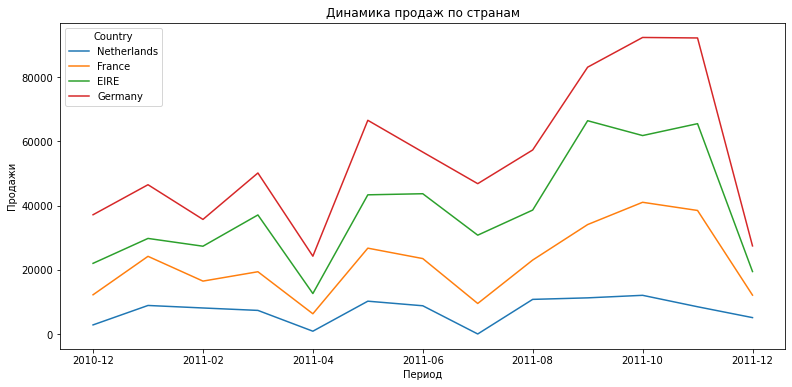

In [31]:
# Можно визуализировать динамику продаж по месяцам в разрезе стран (с накоплением).
# Возьмем только страны ТОП-4 (без Великобритании).
df_dynamics[['Netherlands', 'France', 'EIRE', 'Germany']].plot(
                kind='line',
                stacked=True,
                title='Динамика продаж по странам', 
                xlabel='Период', 
                ylabel='Продажи')

<AxesSubplot:xlabel='Date'>

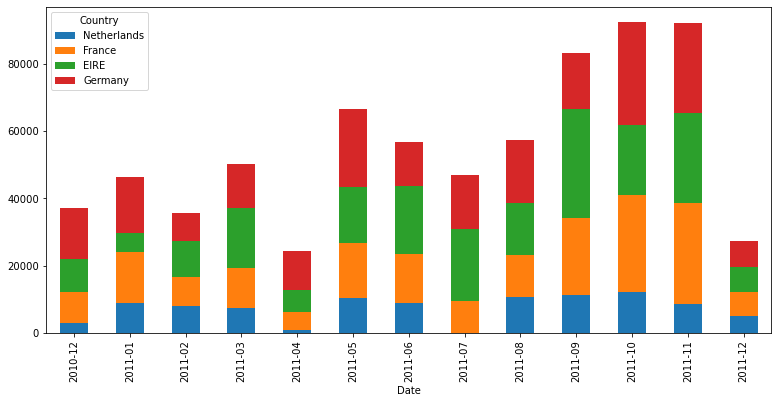

In [32]:
# Столбчатая диаграмма с накоплением.
df_dynamics[['Netherlands', 'France', 'EIRE', 'Germany']].plot(kind='bar', stacked=True)

Text(0, 0.5, 'Продажи')

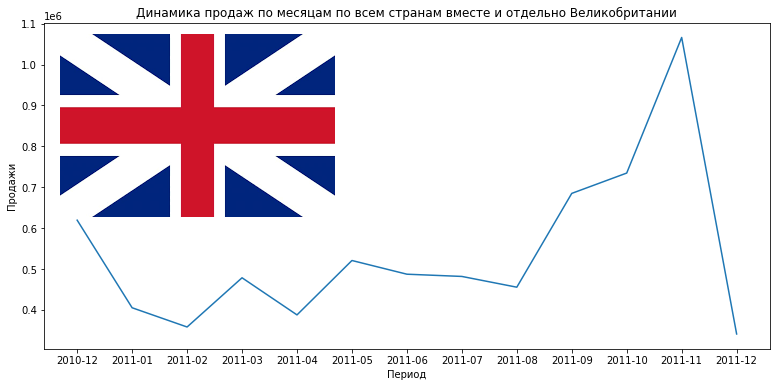

In [33]:
# Дальше посмотрим отдельно на динамику Великобритании, так как это домашний и самый покупающий регион.
# На графике заметен пик продаж в ноябре, можно проанализировать причины, за счет чего, прогнозы и ожидания.
im = image.imread('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS0qQYNdjfAFd5wsldpDICqK6HfhkfWwBiEeQ&usqp=CAU') # Image
fig, ax = plt.subplots()
fig.figimage(im, 60, 170, cmap='ocean', alpha=1) 

plt.plot(df_dynamics.index, df_dynamics['United Kingdom'])
plt.title('Динамика продаж по месяцам по всем странам вместе и отдельно Великобритании')
plt.xlabel('Период')
plt.ylabel('Продажи')

## Анализ возвращающихся клиентов

In [50]:
# Здесь посмотрим на возвращающихся клиентов (более 12 покупок за период). 
df_clients = df.pivot_table(index='CustomerID', values='InvoiceNo', aggfunc=pd.Series.nunique)
df_retention = df_clients[df_clients.InvoiceNo > 12].sort_values(by='InvoiceNo', ascending=False).reset_index()
df_retention.head()

,CustomerID,InvoiceNo
0,12748.0,209
1,14911.0,200
2,17841.0,124
3,13089.0,96
4,14606.0,93


In [52]:
# Всего клиентов (зарегистрированных)
len(df.CustomerID.unique())

4286

In [64]:
# Видим, что возвращающихся клиентов - 5% - 231 из 4286.
# то есть retention невысокий
print(len(df_retention.CustomerID))

print(len(df_retention.CustomerID) / len(df.CustomerID.unique()))

231
0.05389640690620625


In [56]:
# Признак здорового бизнеса — когда процент повторных клиентов растет.
# Посмотрим retention в динамике по месяцам - видим, что с мая 2011 по август total retention падал и с сентября стал расти.
df_retention_month = df.pivot_table(index='CustomerID', columns='Date', values='InvoiceNo', aggfunc=pd.Series.nunique, margins=True, fill_value=0)
df_retention_month[df_retention_month.All > 12].tail()

Date,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,All
CustomerID,,,,,,,,,,,,,,
18223.0,1,2,1,2,0,1,2,1,0,1,2,0,1,14
18229.0,2,1,1,1,1,2,2,2,1,3,1,3,0,20
18241.0,0,0,0,0,0,1,2,1,6,3,3,1,0,17
18283.0,0,2,1,0,1,1,2,2,0,1,1,4,1,16
All,1353,958,961,1286,1100,1505,1348,1289,1231,1701,1870,2586,751,17939


<AxesSubplot:title={'center':'Platforms by Global Sales'}, xlabel='Date', ylabel='Sales'>

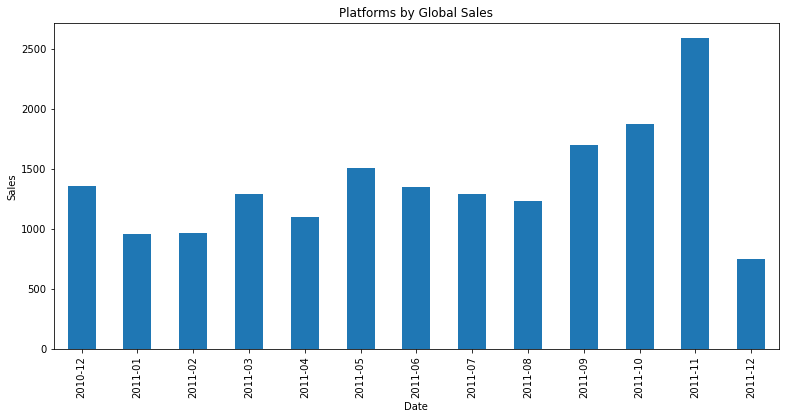

In [58]:
# Для наглядности визуализируем динамику повторных покупок по месяцам
df_retention_month.loc['All'].drop(['All'], axis=0).plot(kind='bar', 
                                title='Platforms by Global Sales',
                                xlabel='Date',
                                ylabel='Sales')

In [59]:
# Посмотрим также на отток клиентов (те, кто купил один раз и отвалился)
df_churn = df_clients[df_clients.InvoiceNo <= 1].reset_index()
df_churn.head()

,CustomerID,InvoiceNo
0,12349.0,1
1,12350.0,1
2,12353.0,1
3,12354.0,1
4,12355.0,1


In [60]:
# Таких клиентов немало - 1482, 35%.
print(len(df_churn.CustomerID))
print(len(df_churn.CustomerID) / len(df.CustomerID.unique()))

1482
0.3457769482034531


#### Делаем вывод, что компании необходимо работать над удержанием клиентов.

## Построим модель линейной регрессии, где целевой переменной будут сгруппированные объёмы продаж по месяцам

In [85]:
# За основу возьмем сводную таблицу по месяцам продаж df_month
df_model = df_month[['Date', 'Summa']]
# удалим последний месяц декабрь 2011, так как он не полный, чтобы не портить картину для модели.
df_model = df_model.drop(df_model[df_model.Date == '2011-12'].index)
df_model.head(15)

,Date,Summa
0,2010-12,679229.360
1,2011-01,487331.460
2,2011-02,421612.830
3,2011-03,569294.450
4,2011-04,440250.891
5,2011-05,616522.170
6,2011-06,584107.230
7,2011-07,562863.221
8,2011-08,551863.230
9,2011-09,808330.502


In [86]:
# Разделим значения столбца InvoiceDate на два (год и месяц)
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model['Month'] = df_model['Date'].dt.month 
df_model['Year'] = df_model['Date'].dt.year

df_model.head()

,Date,Summa,Month,Year
0,2010-12-01,679229.360,12,2010
1,2011-01-01,487331.460,1,2011
2,2011-02-01,421612.830,2,2011
3,2011-03-01,569294.450,3,2011
4,2011-04-01,440250.891,4,2011


In [87]:
# Отделим колонки с признаками от колонки с целевой переменной (будем предсказывать сумму продаж за месяц)
X = df_model[['Month', 'Year']]
y = df_model['Summa']

In [88]:
# Разделим данные на часть для обучения и часть для проверки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [89]:
# Посмотрим какой период попал в тестовую выборку, чтобы потом сравнить прогнозы модели
X_test

,Month,Year
11,11,2011
2,2,2011
1,1,2011


In [90]:
# Приведем данные к одному масштабу при помощи StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [91]:
# Строим модель и обучаем ее
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [92]:
model.coef_

array([128409.83571003,  64255.69252279])

In [93]:
# Посмотрим на тестовые значения продаж
# Проверим с фактическими значениями, видим, что они достаточно близки.
y_pred = model.predict(X_test)
y_pred

array([837276.15367858, 419554.04232146, 373140.47439289])

In [94]:
# Рассчитаем значение коэффициента детерминации - доля дисперсии суммы продаж, объясняемая рассматриваемой моделью.
# Коэфф детерминации означает, что зависимость продаж обусловлена на 60% периодом, а на 40% влиянием прочих факторов (ошибка обобщения).
# Т.е. мы на 60% смогли уловить в нашей модели те зависимости, которые влияют на целевую переменную.
model.score(X_test, y_test)

0.6015961062413391

In [102]:
# Запишем в переменную X_pred будущие три месяца
d = {'Month': [12, 1, 2], 'Year': [2011, 2012, 2012]}
X_pred = pd.DataFrame(data=d)

# Приведем X_pred к одному масштабу с остальными данными при помощи StandardScaler
X_pred = sc.transform(X_pred)

In [101]:
# Построим прогнозы продаж на Декабрь 2011, Январь и Февраль 2012
y_pred_future = model.predict(X_pred)
y_pred_future

# Если сравнивать с соответствующими периодами прошлого года, то модель прогнозирует прирост продаж от 20 до 40%

array([883689.72160715, 577600.83600006, 624014.40392863])

## Оценим качество модели на X_test, y_test при помощи метрик для задачи регрессии. Метрика RMSE (Среднеквадратическая ошибка предсказаний от правильных значений)

In [53]:
rmse_train = sqrt(mean_squared_error(y_train, model.predict(X_train)))
rmse_train

136898.01469042775

In [54]:
rmse_test = sqrt(mean_squared_error(y_test, model.predict(X_test)))
rmse_test

66200.12720188775

* RMSE выражает среднюю ошибку прогнозирования модели в единицах интересующей переменной, в данном случае в фунтах стерлингов. 

* Эта метрика может находиться в диапазоне от 0 до ∞ и безразлична к направлению ошибок. Чем ниже значение, тем лучше.
* В нашей тестовой выборке RMSE меньше и составляет 66200 фунтов, то есть наши прогнозы могут ошибаться на +/-66200 фунтов, что не так много для наших сумм.